# Baseline Model Experiment Validation

## Data Transformation for Bands  

In [1]:
import os 
import sys 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
# Pytorch module 
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning as pl

import random
from typing import Any, Mapping
from time import gmtime, strftime

# set working directory
os.chdir('/home/jovyan/contrails/contrails_detection/')

# Project Module
import config
import src.utils as utils
from src.dataset import ContrailsDataset
from src.model import BaseUnet, SegmentLightning
from src.train import Trainer
from src.trainer_lgt import TrainerLightning

In [2]:
## Load file from csv split into train/test
from sklearn.model_selection import train_test_split
df = pd.read_csv('/home/jovyan/contrails/data/validation_mask_record.csv', index_col=0)
train_df, valid_df = train_test_split(df[df.Class.isin([0,1])], test_size = .2, random_state=42)
train_df.tail()

,Image_ID,Class
1131,1288917852422534876,1
1295,135845313190230696,1
861,1006793757071532139,0
1460,144592648300779276,0
1127,1101876205139670330,0


In [15]:
%%time
torch.manual_seed(11)
transform = transforms.Compose([
    # Add your desired transformations here
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.0),
    transforms.Lambda(lambda x: utils.get_ashrgb_tfb(x)), 
    #transforms.Lambda(lambda x: utils.get_wv_ash(x))
])

train_dataset_1 = ContrailsDataset(dataframe=train_df[train_df.Class==1],
                                 root_dir=config.DATA_DIR+'validation', 
                                 transform=transform, 
                                 sequence_index=config.TS # nth:4 sequence image
                                ) 

train_dataset_2 = ContrailsDataset(dataframe=train_df[train_df.Class==0], 
                                 root_dir=config.DATA_DIR+'validation',
                                 transform=transform, 
                                 sequence_index=config.TS
                                )
## Data Loaders
train_dataloader_1 = DataLoader(train_dataset_1,
                              batch_size=config.BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=config.WORKERS, 
                              pin_memory=True, 
                              prefetch_factor=config.WORKERS,
                             )

train_dataloader_2 = DataLoader(train_dataset_2, 
                              batch_size=config.BATCH_SIZE, 
                              shuffle=False, 
                              num_workers=config.WORKERS, 
                              prefetch_factor=config.WORKERS
                             )

CPU times: user 6.95 ms, sys: 0 ns, total: 6.95 ms
Wall time: 6.01 ms


In [16]:
%%time
image_1, mask_1 = next(iter(train_dataloader_1))
image_1.shape, mask_1.shape

CPU times: user 30 ms, sys: 309 ms, total: 339 ms
Wall time: 700 ms


(torch.Size([4, 6, 256, 256]), torch.Size([4, 1, 256, 256]))

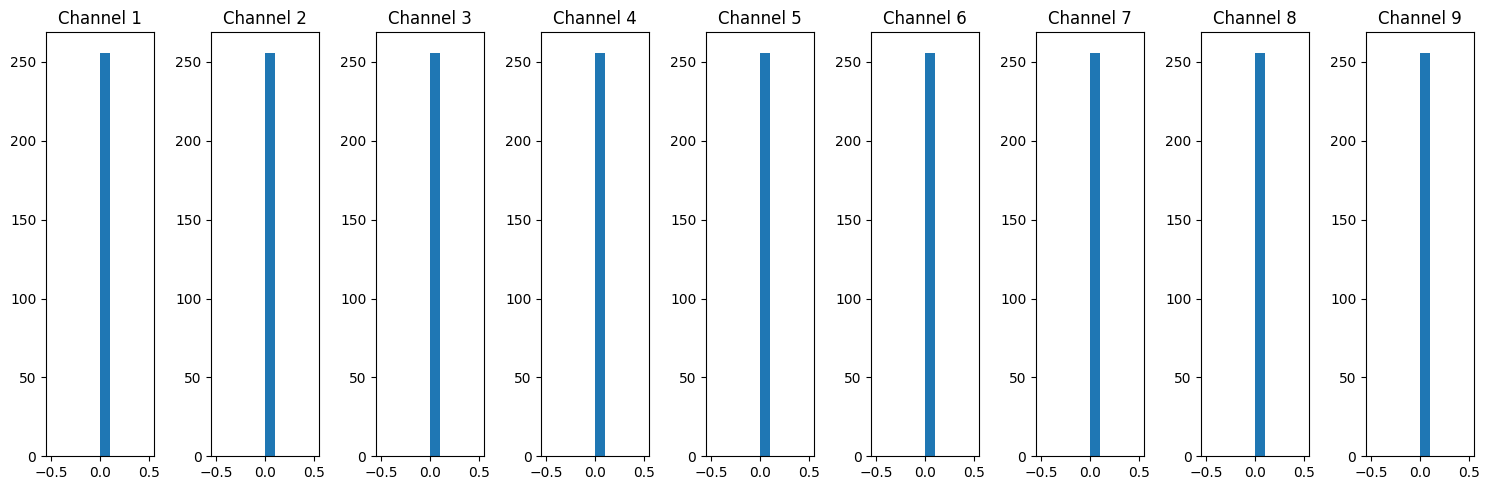

In [6]:
# Function to compute histograms for a batch of images
def compute_histograms(inputs):
    num_channels = inputs.shape[1]
    histograms = []

    for i in range(num_channels):
        channel = inputs[:, i, :, :]
        hist = torch.histc(channel, bins=256, min=0, max=1)
        histograms.append(hist.numpy())

    return histograms

# Loop through the train dataset in batches
all_histograms = None

for data in train_dataloader_1:
    inputs, labels = data
    num_channels = inputs.shape[1]

    if all_histograms is None:
        all_histograms = [np.zeros(256) for _ in range(num_channels)]

    batch_histograms = compute_histograms(inputs)

    for i in range(num_channels):
        all_histograms[i] += batch_histograms[i]

# Plot the combined histograms
fig, ax = plt.subplots(1, len(all_histograms), figsize=(15, 5))

for i in range(len(all_histograms)):
    if len(all_histograms) == 1:
        ax.hist(all_histograms[i])
        ax.set_title('Histogram for All Images')
    else:
        ax[i].hist(all_histograms[i])
        ax[i].set_title(f'Channel {i+1}')

plt.tight_layout()
plt.show()

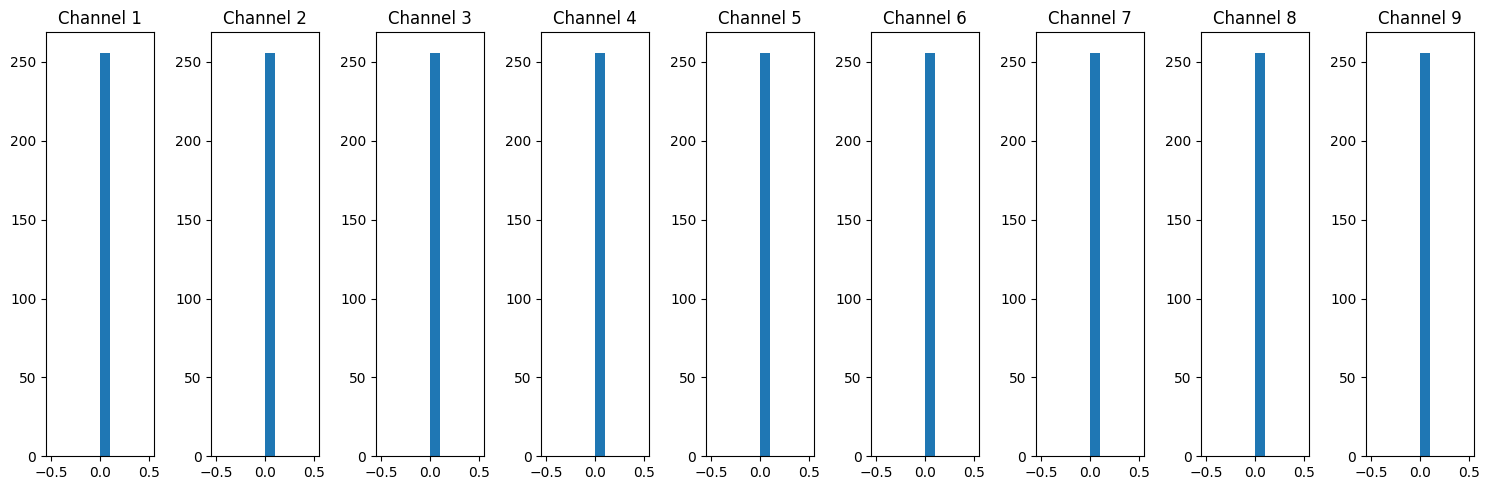

In [7]:
# Loop through the train dataset in batches
all_histograms = None

for data in train_dataloader_2:
    inputs, labels = data
    num_channels = inputs.shape[1]

    if all_histograms is None:
        all_histograms = [np.zeros(256) for _ in range(num_channels)]

    batch_histograms = compute_histograms(inputs)

    for i in range(num_channels):
        all_histograms[i] += batch_histograms[i]

# Plot the combined histograms
fig, ax = plt.subplots(1, len(all_histograms), figsize=(15, 5))

for i in range(len(all_histograms)):
    if len(all_histograms) == 1:
        ax.hist(all_histograms[i])
        ax.set_title('Histogram for All Images')
    else:
        ax[i].hist(all_histograms[i])
        ax[i].set_title(f'Channel {i+1}')

plt.tight_layout()
plt.show()

In [ ]:
utils.plot_batch_histogram(image_1)

In [ ]:
image_0, mask_0 = next(iter(train_dataloader_2))
utils.plot_batch_histogram(image_0)

In [ ]:
utils.plot_rgb_and_mask(image_1, mask_1)

In [ ]:
utils.plot_rgb_and_mask(image_0, mask_0)

In [ ]:
image_p, mask_p = next(iter(valid_dataloader))
image_p.shape

### Baseline U-Net ALL channel result analysis 

In [6]:
!ls models/checkpoints/Obj1/baseline-unetALL
config.NAME+config.BANDS

'epoch=13-step=57484.ckpt'  'epoch=20-step=86226.ckpt'
'epoch=14-step=61590.ckpt'  'epoch=22-step=94438.ckpt'
'epoch=19-step=82120.ckpt'   last.ckpt


'baseline-unetALL'

In [7]:
_expr_name = config.NAME+config.BANDS
norm_checkpoint_path = config.MODEL_DIR+"/"+_expr_name + "/epoch=22-step=94438.ckpt"
checkpoint = torch.load(norm_checkpoint_path)
# Extract the state_dict from the checkpoint
saved_state_dict = checkpoint['state_dict']
prefix = "model."  # Adjust the prefix as needed
filtered_state_dict = {k[len(prefix):]: v for k, v in saved_state_dict.items() if k.startswith(prefix)}

model_v = BaseUnet(in_channels=9, out_channels=1)
model_v.load_state_dict(filtered_state_dict)
model_v.eval()

model = model_v.to(config.DEVICE)
data = image_1.to(config.DEVICE)
prediction = torch.sigmoid(model_v(data))
#utils.plot_rgb_and_mask(image_p, mask_p, prediction.detach())

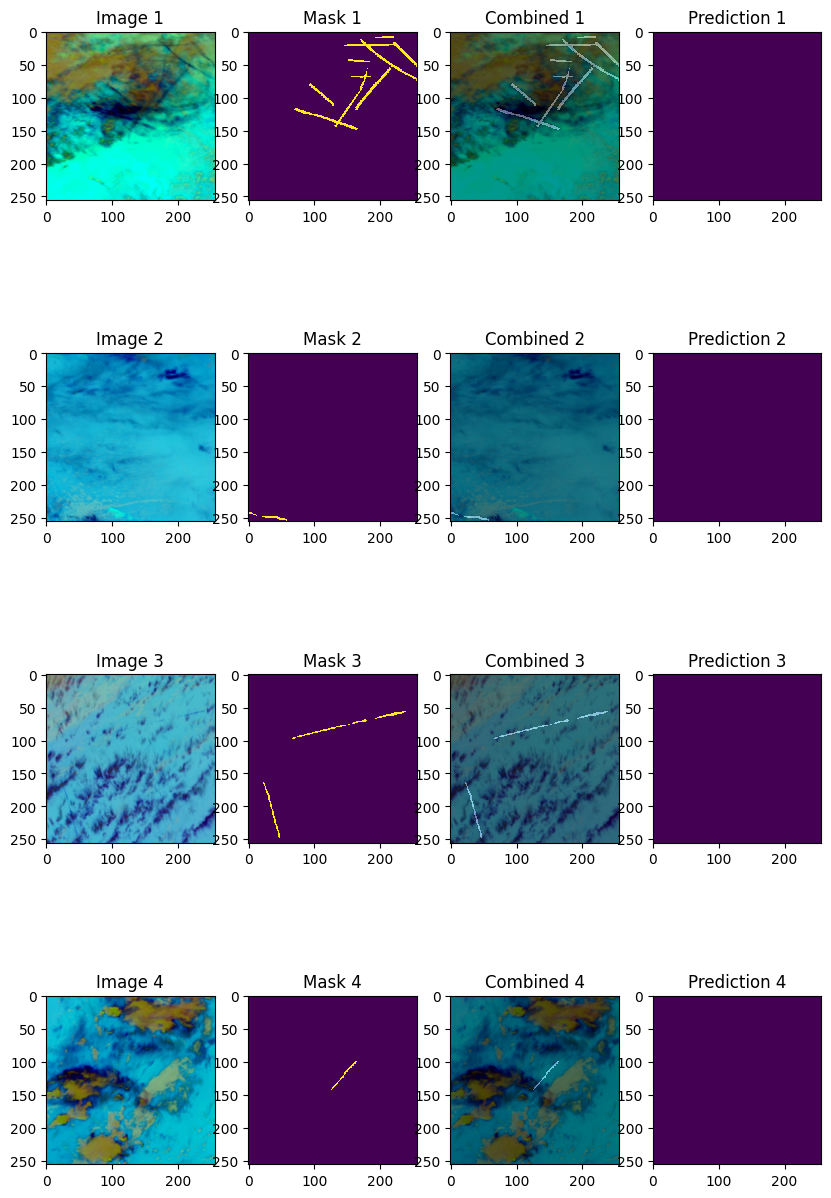

In [9]:
utils.plot_rgb_and_mask(image_1, mask_1, prediction.detach() > 0.4)

### Baseline Ash RGB model result

In [10]:
config.NAME+"AshRGB"

'baseline-unetAshRGB'

In [13]:
_expr_name = config.NAME+"AshRGB"
norm_checkpoint_path = config.MODEL_DIR+"/"+_expr_name + "/last-v1.ckpt"
checkpoint = torch.load(norm_checkpoint_path)
# Extract the state_dict from the checkpoint
saved_state_dict = checkpoint['state_dict']
prefix = "model."  # Adjust the prefix as needed
filtered_state_dict = {k[len(prefix):]: v for k, v in saved_state_dict.items() if k.startswith(prefix)}

model_v = BaseUnet(in_channels=3, out_channels=1)
model_v.load_state_dict(filtered_state_dict)
model_v.eval()

model = model_v.to(config.DEVICE)
data = image_1.to(config.DEVICE)
prediction = torch.sigmoid(model_v(data))

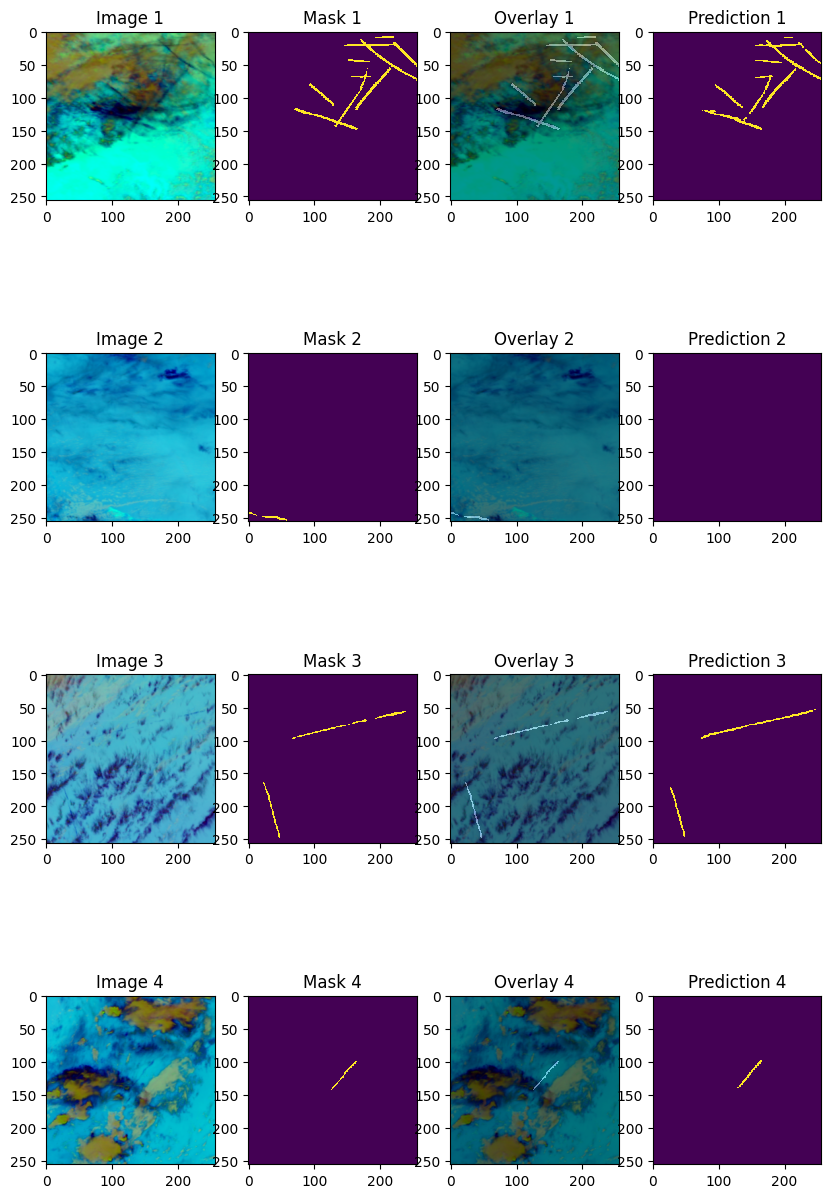

In [14]:
utils.plot_image_and_mask(image_1, mask_1, prediction.detach() > 0.4)

## Model Result for AshRGB & Random forest importance feature

In [17]:
_expr_name = config.NAME+"AshRGB_RFCH"
norm_checkpoint_path = config.MODEL_DIR+"/"+_expr_name + "/last.ckpt"
checkpoint = torch.load(norm_checkpoint_path)
# Extract the state_dict from the checkpoint
saved_state_dict = checkpoint['state_dict']
prefix = "model."  # Adjust the prefix as needed
filtered_state_dict = {k[len(prefix):]: v for k, v in saved_state_dict.items() if k.startswith(prefix)}

model_v = BaseUnet(in_channels=6, out_channels=1)
model_v.load_state_dict(filtered_state_dict)
model_v.eval()

model = model_v.to(config.DEVICE)
data = image_1.to(config.DEVICE)
prediction = torch.sigmoid(model_v(data))

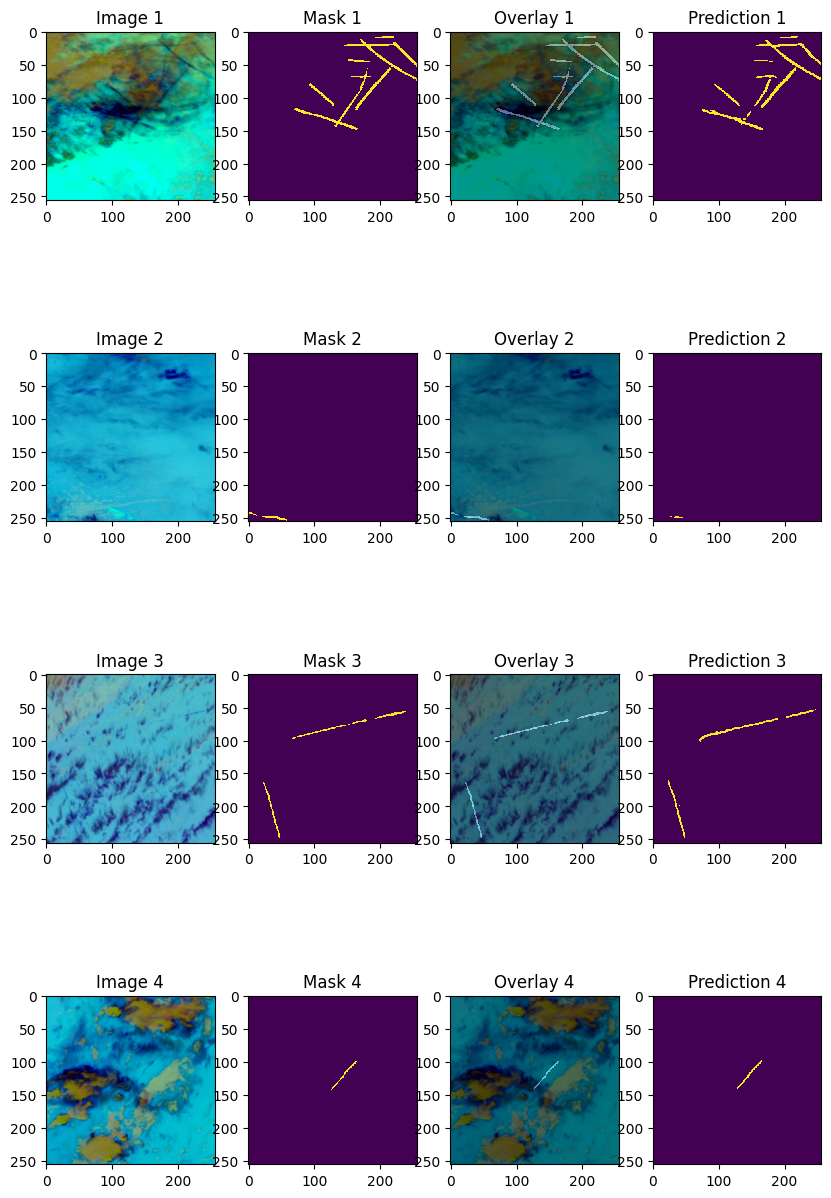

In [18]:
utils.plot_image_and_mask(image_1, mask_1, prediction.detach() > 0.4)